# Lab05 Advice for Applying Machine Learning

## 1 - Packages

In [1]:
import numpy as np
%matplotlib widget

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)

tf.keras.backend.set_floatx('float64')

from lab_utils import *

tf.autograph.set_verbosity(0)

## 2 - Evaluate a Learning Algorithm (Polynomial Regression)

Split your data set.

In [2]:
# Generate some data
X, y, x_ideal, y_ideal = gen_data(18, 2, 0.7)
print('X.shape', X.shape, 'y.shape', y.shape)

# Split the data using sklearn routine
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print('X_train.shape', X_train.shape, 'y_train.shape', y_train.shape)
print('X_test.shape', X_test.shape, 'y_test.shape', y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


Plot train and test sets.

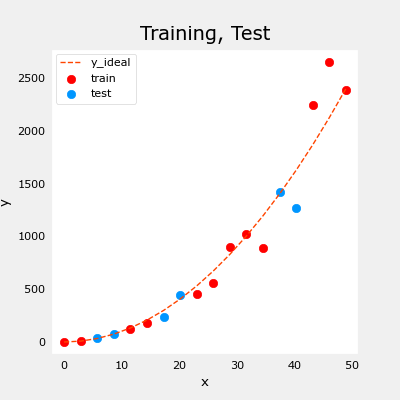

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(x_ideal, y_ideal, '--', color='orangered', label='y_ideal', lw=1)
ax.set_title('Training, Test', fontsize=14)
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.scatter(X_train, y_train, color='red', label='train')
ax.scatter(X_test, y_test, color=dlc['dlblue'], label='test')
ax.legend(loc='upper left')
plt.show()

When evaluating a linear regression model, you average the squared error difference of the predicted values and the target values.

$$
J_\text{test}(\mathbf{w},b)=\frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2\tag{1}
$$

Below, create a function to evaluate the error on a data set for a linear regression model.

In [4]:
def eval_mse(y, yhat):
    """
    Calculate the mean squared error on a data set.

    Args:
        y (ndarray Shape (m,) or (m,1)): Target value of each example
        yhat (ndarray Shape (m,) or (m,1)): Predicted value of each example

    Returns:
        err (scalar): Error
    """

    m = len(y)
    err = 0.0

    for i in range(m):
        err += (y[i] - yhat[i]) ** 2

    err /= (2 * m)

    return err

Compare performance on training and test data.

Let's build a high degree polynomial model to minimize training error. This will use the linear_regression functions from `sklearn`. The steps below are:

- Create and fit the model ("fit" is another name for training or running gradient descent).
- Compute the error on the training data.
- Compute the error on the test data.

In [5]:
# Create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# Predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# Predict on test data, find test error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

print(f'training err = {err_train:0.2f} , test err = {err_test:0.2f}')

training err = 58.01 , test err = 171215.01


The model fits the training data very well. To do so, it has created a complex function. The test data was not part of the training and the model does a poor job of predicting on this data.

This model would be described as:

- overfitting
- high variance
- generalizes poorly

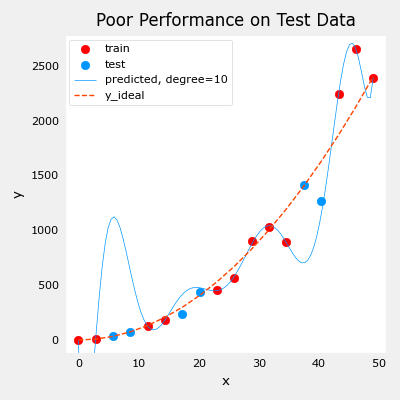

In [6]:
# Plot predictions over data range
x = np.linspace(0, int(X.max()), 100)
y_pred = lmodel.predict(x).reshape(-1, 1)
plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied depending on the amount of data available.

| Data             | % of total | Description |
|:-----------------|:----------:|:------------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network |
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |

Let's generate three data sets below. We'll once again use `train_test_split` from `sklearn` but will call it twice to get three splits.

In [7]:
# Generate data
X, y, x_ideal, y_ideal = gen_data(40, 5, 0.7)
print('X.shape', X.shape, 'y.shape', y.shape)

# Split the data using sklearn routine
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.50, random_state=1)
print('X_train.shape', X_train.shape, 'y_train.shape', y_train.shape)
print('X_cv.shape', X_cv.shape, 'y_cv.shape', y_cv.shape)
print('X_test.shape', X_test.shape, 'y_test.shape', y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


## 3 - Bias and Variance

Plot train, cross-Validation and test.

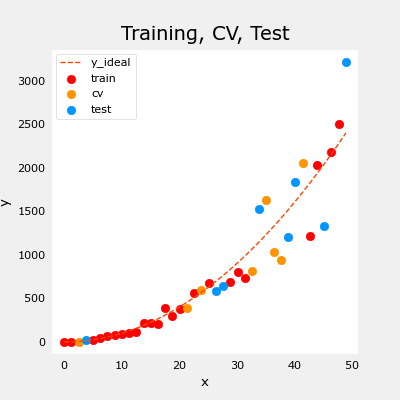

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(x_ideal, y_ideal, '--', color='orangered', label='y_ideal', lw=1)
ax.set_title('Training, CV, Test', fontsize=14)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.scatter(X_train, y_train, color='red', label='train')
ax.scatter(X_cv, y_cv, color=dlc['dlorange'], label='cv')
ax.scatter(X_test, y_test, color=dlc['dlblue'], label='test')
ax.legend(loc='upper left')
plt.show()

Find the optimal degree.

In [9]:
max_degree = 9
err_train = np.zeros(max_degree)
err_cv = np.zeros(max_degree)
x = np.linspace(0, int(X.max()), 100)
y_pred = np.zeros((100, max_degree))

for degree in range(max_degree):
    lmodel = lin_model(degree + 1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:, degree] = lmodel.predict(x)

optimal_degree = np.argmin(err_cv) + 1

Let's plot the result.

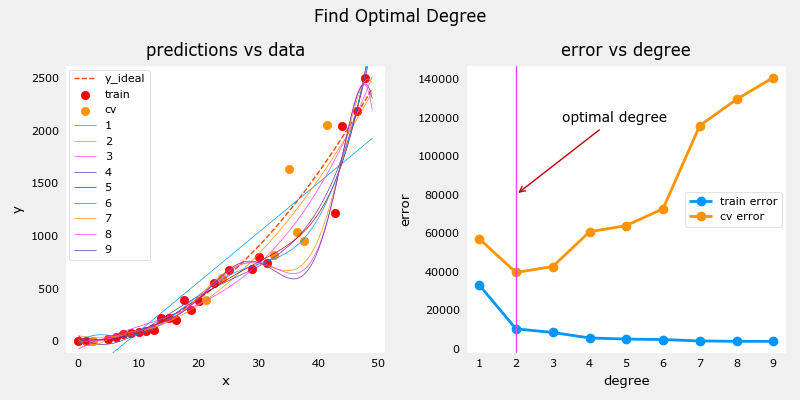

In [10]:
plt.close('all')
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, err_train, err_cv, optimal_degree,
                   max_degree)

Regularization.

In [11]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)
err_cv = np.zeros(num_steps)
x = np.linspace(0, int(X.max()), 100)
y_pred = np.zeros((100, num_steps))

for i in range(num_steps):
    lambda_ = lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:, i] = lmodel.predict(x)

optimal_reg_idx = np.argmin(err_cv)

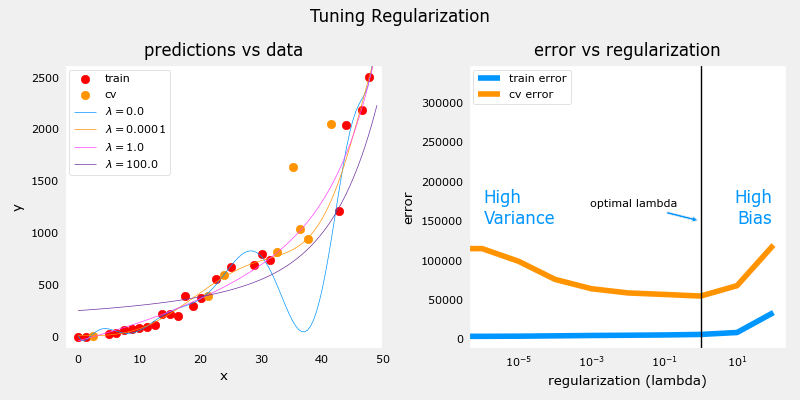

In [12]:
plt.close('all')
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that as regularization increases, the model moves from a **high variance (overfitting) model** to a **high bias (underfitting) model**.

The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10.

When a model is overfitting (high variance), collecting additional data can improve performance.

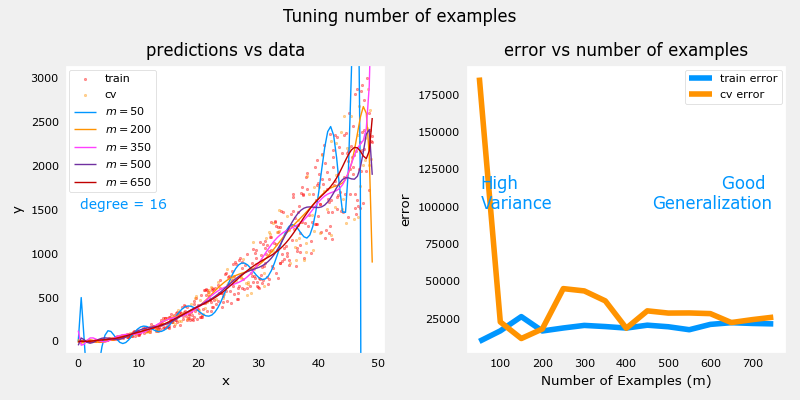

In [13]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. Note the curves on the left plot. The final curve with the highest value of $m$ is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values. The trend remains clear: more data improves generalization.

Note that adding more examples when the model has high bias (underfitting) does not improve performance.

## 4 - Evaluate a Learning Algorithm (Neural Network)

Run the cell below to generate a data set and split it into training, cross-validation (CV) and test sets. In this example, we're increasing the percentage of cross-validation data points for emphasis.

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


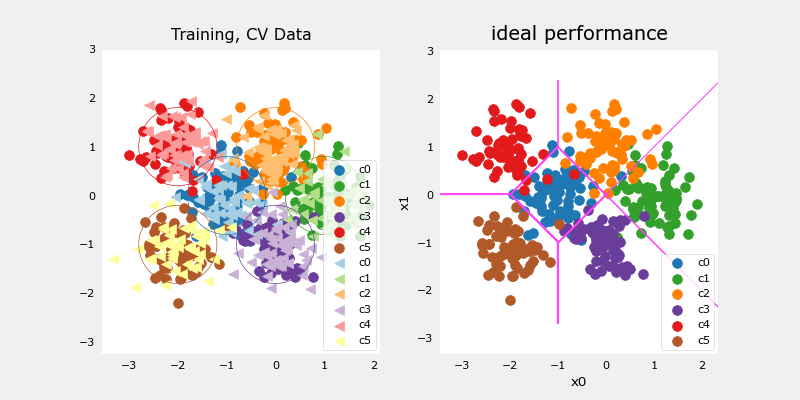

In [14]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# Split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.20, random_state=1)
print('X_train.shape:', X_train.shape, 'X_cv.shape:', X_cv.shape, 'X_test.shape:', X_test.shape)

plt_train_eq_dist(X_train, y_train, classes, X_cv, y_cv, centers, std)

The evaluation function for categorical models used here is simply the fraction of incorrect predictions:

$$
J_{cv}=\frac{1}{m}\sum_{i=0}^{m-1}
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

Below, complete the routine to calculate classification error. Note, in this lab, target values are the index of the category and are not one-hot encoded.

In [15]:
def eval_cat_err(y, yhat):
    """
    Calculate the categorization error.

    Args:
        y (ndarray  Shape (m,) or (m,1)): Target value of each example
        yhat (ndarray  Shape (m,) or (m,1)): Predicted value of each example

    Returns:
        cerr (scalar): error
    """

    m = len(y)
    cerr = 0

    for i in range(m):
        if (y[i] != yhat[i]):
            cerr += 1

    cerr /= m

    return cerr

## 5 - Model Complexity

Below, you will build two models. A complex model and a simple model.

### 5.1 Complex Model

In [16]:
import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)

tf.random.set_seed(1234)

model = Sequential(
    [
        Dense(120, activation='relu', name='L1'),
        Dense(40, activation='relu', name='L2'),
        Dense(classes, activation='linear', name='l3')
    ], name='Complex'
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01)
)

model.fit(
    X_train,
    y_train,
    epochs=1000
)

Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9563
Epoch 2/1000
13/13 [==============================] - 0s 747us/step - loss: 0.3956
Epoch 3/1000
13/13 [==============================] - 0s 748us/step - loss: 0.3125
Epoch 4/1000
13/13 [==============================] - 0s 747us/step - loss: 0.2802
Epoch 5/1000
13/13 [==============================] - 0s 831us/step - loss: 0.2792
Epoch 6/1000
13/13 [==============================] - 0s 831us/step - loss: 0.2841
Epoch 7/1000
13/13 [==============================] - 0s 914us/step - loss: 0.2344
Epoch 8/1000
13/13 [==============================] - 0s 914us/step - loss: 0.2180
Epoch 9/1000
13/13 [==============================] - 0s 914us/step - loss: 0.2225
Epoch 10/1000
13/13 [==============================] - 0s 878us/step - loss: 0.1957
Epoch 11/1000
13/13 [==============================] - 0s 914us/step - loss: 0.2114
Epoch 12/1000
13/13 [==============================] - 0s 914us/step - loss: 0.2035
Epo

Model: "Complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 120)               360       
                                                                 
 L2 (Dense)                  (None, 40)                4840      
                                                                 
 l3 (Dense)                  (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
1082/1082 [==============================] - 1s 520us/step


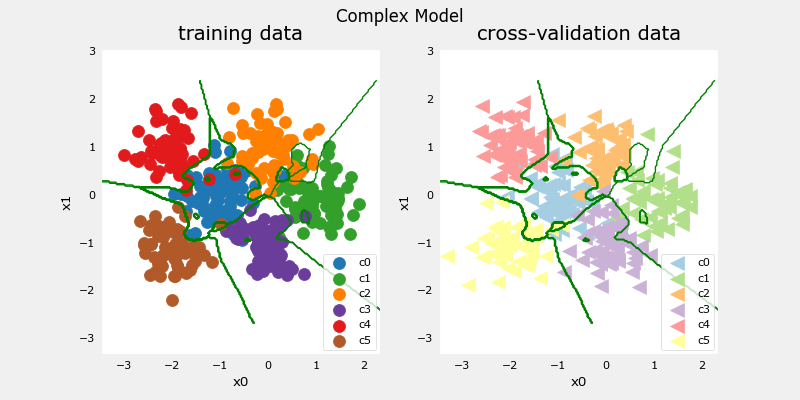

In [17]:
model.summary()

model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(), axis=1)
plt_nn(model_predict, X_train, y_train, classes, X_cv, y_cv, suptitle='Complex Model')

This model has worked very hard to capture outliers of each category. As a result, it has miscategorized some of the cross-validation data. Let's calculate the classification error.

In [18]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f'categorization error, training, complex model: {training_cerr_complex:0.3f}')
print(f'categorization error, cv,       complex model: {cv_cerr_complex:0.3f}')

10/10 [==============================] - 0s 776us/step
categorization error, training, complex model: 0.013
categorization error, cv,       complex model: 0.113


### 5.2 Simple Model

In [19]:
import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)

tf.random.set_seed(1234)

model_s = Sequential(
    [
        Dense(6, activation='relu', name='L1'),
        Dense(classes, activation='linear', name='L2')
    ], name='Simple'
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01)
)

model_s.fit(
    X_train,
    y_train,
    epochs=1000
)

Epoch 1/1000
13/13 [==============================] - 0s 914us/step - loss: 1.8980
Epoch 2/1000
13/13 [==============================] - 0s 664us/step - loss: 1.6088
Epoch 3/1000
13/13 [==============================] - 0s 665us/step - loss: 1.4138
Epoch 4/1000
13/13 [==============================] - 0s 997us/step - loss: 1.2459
Epoch 5/1000
13/13 [==============================] - 0s 914us/step - loss: 1.0813
Epoch 6/1000
13/13 [==============================] - 0s 748us/step - loss: 0.9262
Epoch 7/1000
13/13 [==============================] - 0s 664us/step - loss: 0.8044
Epoch 8/1000
13/13 [==============================] - 0s 748us/step - loss: 0.6998
Epoch 9/1000
13/13 [==============================] - 0s 664us/step - loss: 0.6179
Epoch 10/1000
13/13 [==============================] - 0s 665us/step - loss: 0.5487
Epoch 11/1000
13/13 [==============================] - 0s 748us/step - loss: 0.4949
Epoch 12/1000
13/13 [==============================] - 0s 665us/step - loss: 0.4518
E

Model: "Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 6)                 18        
                                                                 
 L2 (Dense)                  (None, 6)                 42        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
1082/1082 [==============================] - 1s 464us/step


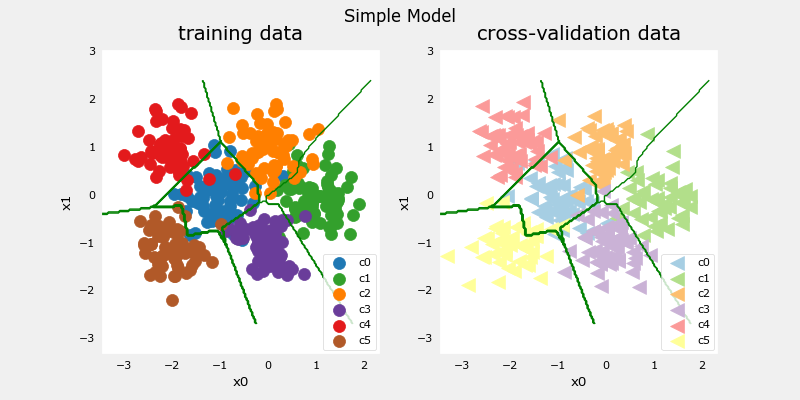

In [20]:
model_s.summary()

model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(), axis=1)
plt_nn(model_predict_s, X_train, y_train, classes, X_cv, y_cv, suptitle='Simple Model')

This simple models does pretty well. Let's calculate the classification error.

In [21]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f'categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}')
print(f'categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}')

10/10 [==============================] - 0s 775us/step
categorization error, training, simple model, 0.058, complex model: 0.013
categorization error, cv,       simple model, 0.087, complex model: 0.113


Our simple model has a little higher classification error on training data but does better on cross-validation data than the more complex model.

## 6 - Regularization

As in the case of polynomial regression, one can apply regularization to moderate the impact of a more complex model.

In [22]:
tf.random.set_seed(1234)

model_r = Sequential(
    [
        Dense(120, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name='L1'),
        Dense(40, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name='L2'),
        Dense(classes, activation='linear', name='L3')
    ], name='ComplexRegularized'
)

model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01)
)

model_r.fit(
    X_train,
    y_train,
    epochs=1000
)

Epoch 1/1000
13/13 [==============================] - 0s 997us/step - loss: 4.4579
Epoch 2/1000
13/13 [==============================] - 0s 748us/step - loss: 1.6859
Epoch 3/1000
13/13 [==============================] - 0s 831us/step - loss: 1.3148
Epoch 4/1000
13/13 [==============================] - 0s 747us/step - loss: 1.0631
Epoch 5/1000
13/13 [==============================] - 0s 748us/step - loss: 0.9956
Epoch 6/1000
13/13 [==============================] - 0s 831us/step - loss: 0.9380
Epoch 7/1000
13/13 [==============================] - 0s 747us/step - loss: 0.9229
Epoch 8/1000
13/13 [==============================] - 0s 831us/step - loss: 0.8655
Epoch 9/1000
13/13 [==============================] - 0s 852us/step - loss: 0.8006
Epoch 10/1000
13/13 [==============================] - 0s 833us/step - loss: 0.7682
Epoch 11/1000
13/13 [==============================] - 0s 798us/step - loss: 0.7546
Epoch 12/1000
13/13 [==============================] - 0s 793us/step - loss: 0.7424
E

Model: "ComplexRegularized"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 120)               360       
                                                                 
 L2 (Dense)                  (None, 40)                4840      
                                                                 
 L3 (Dense)                  (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
1082/1082 [==============================] - 1s 538us/step


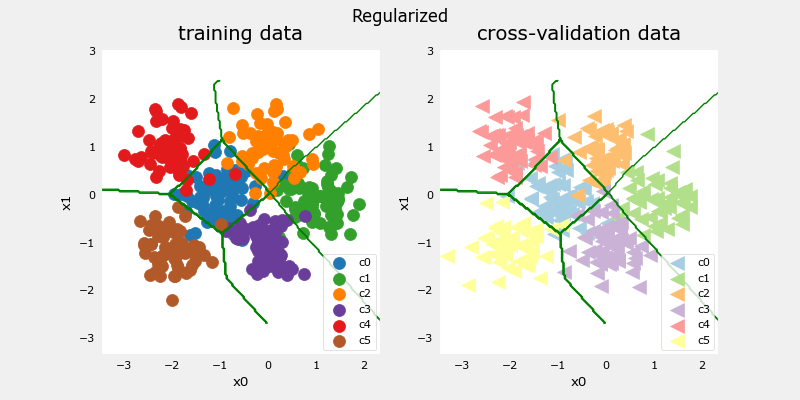

In [23]:
model_r.summary()

model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(), axis=1)
plt_nn(model_predict_r, X_train, y_train, classes, X_cv, y_cv, suptitle='Regularized')

The results look very similar to the ideal model. Let's check classification error.

In [24]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f'categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}')
print(f'categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}')

3/3 [==============================] - 0s 998us/step
categorization error, training, regularized: 0.062, simple model, 0.058, complex model: 0.013
categorization error, cv,       regularized: 0.062, simple model, 0.087, complex model: 0.113


The simple model is a bit better in the training set than the regularized model but worse in the cross validation set.

You can iterate to find optimal regularization value.

In [25]:
tf.random.set_seed(1234)

lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models = [None] * len(lambdas)

for i in range(len(lambdas)):
    lambda_ = lambdas[i]

    models[i] = Sequential(
        [
            Dense(120, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation='linear')
        ]
    )

    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01)
    )

    models[i].fit(
        X_train,
        y_train,
        epochs=1000
    )

    print(f'Finished lambda = {lambda_}')

Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9324
Epoch 2/1000
13/13 [==============================] - 0s 748us/step - loss: 0.3810
Epoch 3/1000
13/13 [==============================] - 0s 747us/step - loss: 0.3057
Epoch 4/1000
13/13 [==============================] - 0s 748us/step - loss: 0.2669
Epoch 5/1000
13/13 [==============================] - 0s 748us/step - loss: 0.2466
Epoch 6/1000
13/13 [==============================] - 0s 748us/step - loss: 0.2782
Epoch 7/1000
13/13 [==============================] - 0s 831us/step - loss: 0.2454
Epoch 8/1000
13/13 [==============================] - 0s 831us/step - loss: 0.2299
Epoch 9/1000
13/13 [==============================] - 0s 748us/step - loss: 0.2286
Epoch 10/1000
13/13 [==============================] - 0s 831us/step - loss: 0.1980
Epoch 11/1000
13/13 [==============================] - 0s 914us/step - loss: 0.2179
Epoch 12/1000
13/13 [==============================] - 0s 831us/step - loss: 0.2072
Epo

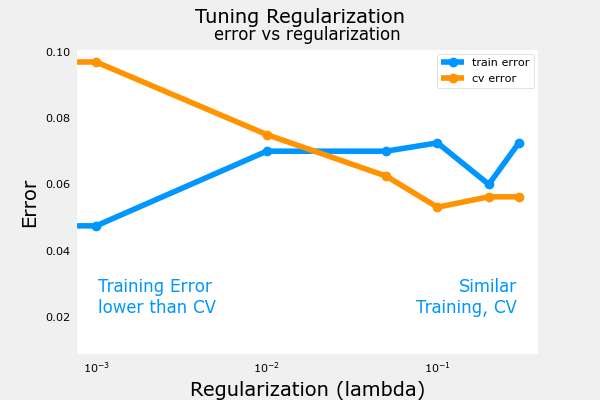

In [26]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.

Let's try our optimized models on the test set and compare them to ideal performance.

3/3 [==============================] - 0s 965us/step


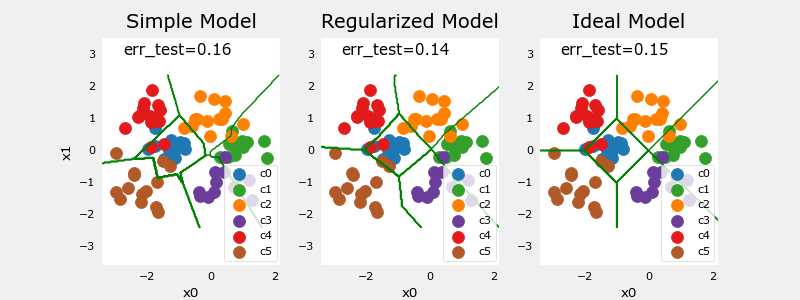

In [27]:
plt_compare(X_test, y_test, classes, model_predict_s, model_predict_r, centers)

Our test set is small and seems to have a number of outliers so classification error is high. However, the performance of our optimized models is comparable to ideal performance.